In [2]:
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix,csr_matrix
import numpy as np

In [3]:
raw_movies = dd.read_csv("/kaggle/input/recommend/movies.csv")
raw_ratings = dd.read_csv("/kaggle/input/recommend/ratings.csv")

In [4]:
raw_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
raw_movies["year"] = raw_movies["title"].str.extract(r"\((\d{4})\)")[0]
raw_movies['title'] = raw_movies['title'].str.replace(r'\s\(\d{4}\)', '', regex=True)
raw_movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [6]:
raw_ratings.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [7]:
raw_movies.isna().sum().compute()

movieId      0
title        0
genres       0
year       615
dtype: int64

# **MOVIES DATASET PREPROCESSING**

In [8]:
raw_movies = raw_movies.dropna(subset=["year"])

In [9]:
raw_movies.isna().sum().compute()


movieId    0
title      0
genres     0
year       0
dtype: int64

In [10]:
raw_ratings.shape[0].compute()

32000204

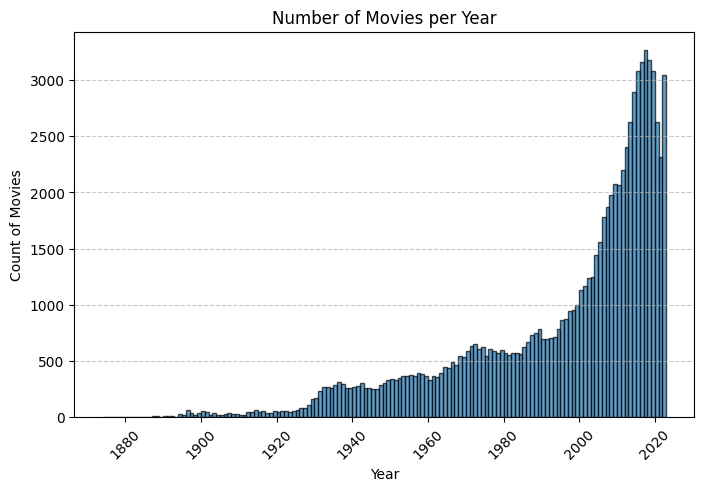

In [11]:
import matplotlib.pyplot as plt

# Drop NaN values from 'year' column
year_counts = raw_movies["year"].dropna().astype(int)

# Compute min and max year values
year_min = year_counts.min().compute()
year_max = year_counts.max().compute()

plt.figure(figsize=(8, 5))
plt.hist(year_counts.compute(), bins=range(year_min, year_max + 1), edgecolor="black", alpha=0.7)

plt.xlabel("Year")
plt.ylabel("Count of Movies")
plt.title("Number of Movies per Year")

plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


In [12]:
raw_movies["year"] = raw_movies["year"].astype(int)

raw_movies = raw_movies[raw_movies["year"] >= 1990 ].compute()


In [13]:
raw_movies.shape[0]

59662

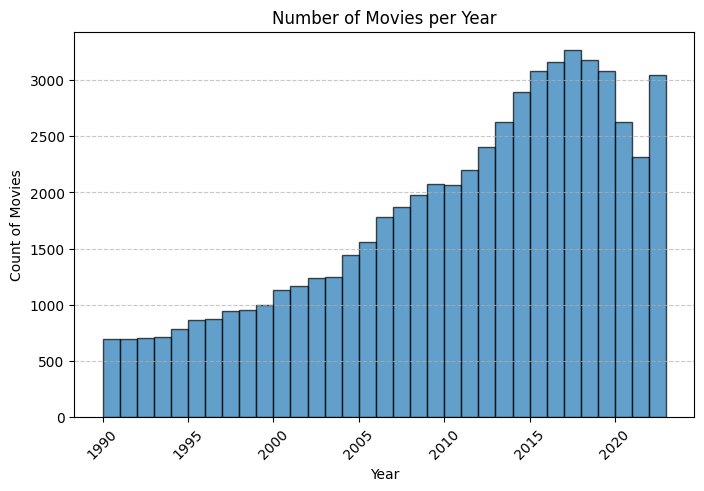

In [14]:
import matplotlib.pyplot as plt

# Drop NaN values from 'year' column
year_counts = raw_movies["year"].dropna().astype(int)

# Compute min and max year values
year_min = year_counts.min()
year_max = year_counts.max()

plt.figure(figsize=(8, 5))
plt.hist(year_counts, bins=range(year_min, year_max + 1), edgecolor="black", alpha=0.7)

plt.xlabel("Year")
plt.ylabel("Count of Movies")
plt.title("Number of Movies per Year")

plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


In [15]:
empty_or_na_count = raw_movies[
    raw_movies["title"].str.strip().isna() | (raw_movies["title"].str.strip() == "")
].shape[0]
print(f"Movies with empty or NaN titles: {empty_or_na_count}")



Movies with empty or NaN titles: 1


In [16]:
raw_movies = raw_movies[
    ~raw_movies["title"].str.strip().isna() & (raw_movies["title"].str.strip() != "")
]


In [17]:
empty_or_na_count = raw_movies[
    raw_movies["title"].str.strip().isna() | (raw_movies["title"].str.strip() == "")
].shape[0]
print(f"Movies with empty or NaN titles: {empty_or_na_count}")

Movies with empty or NaN titles: 0


In [18]:
#Check for movies with jumbled name
#for example "The Avengers" is named as "Avengers, The"
#We need to correct these names as they will pose a problem when recommending

import re

# Function to detect jumbled titles safely
def detect_jumbled_titles(title):
    if isinstance(title, str):  # Check if title is a string
        if re.match(r'(.+), (The|An|A)$', title):
            return True
    return False

# Apply the function to detect jumbled titles with meta specified
# jumbled_titles = raw_movies[raw_movies['title'].apply(detect_jumbled_titles, meta=('title', 'bool'))]
jumbled_titles = raw_movies[raw_movies['title'].apply(detect_jumbled_titles)]

# Compute and print the result
print("Jumbled Titles Detected:")
print(jumbled_titles[['title']])


Jumbled Titles Detected:
                             title
10         American President, The
49             Usual Suspects, The
53                  Big Green, The
59     Indian in the Cupboard, The
77             Crossing Guard, The
...                            ...
34348          Ballerina's Tale, A
34354               Girl King, The
34913           Peanuts Movie, The
36061               Big Short, The
40720    Extraordinary Voyage, The

[1890 rows x 1 columns]


In [19]:
# Function to detect titles with parentheses
def detect_parentheses(title):
    if isinstance(title, str):
        return bool(re.match(r'.+\s\(.+\)$', title))
    return False

# Apply the function to filter movies with extra info in parentheses
# movies_with_info = raw_movies[raw_movies['title'].apply(detect_parentheses, meta=('title', 'bool'))]
movies_with_info = raw_movies[raw_movies['title'].apply(detect_parentheses)]

# Compute and print matching rows
# movies_with_info = movies_with_info.compute()
print("Movies with Extra Info in Title:")
print(movies_with_info[[ 'title']])


Movies with Extra Info in Title:
                                                   title
28     City of Lost Children, The (Cité des enfants p...
29         Shanghai Triad (Yao a yao yao dao waipo qiao)
31                    Twelve Monkeys (a.k.a. 12 Monkeys)
46                                  Seven (a.k.a. Se7en)
57                            Postman, The (Postino, Il)
...                                                  ...
85327                      Aisheen (Still Alive in Gaza)
85494  Miley Cyrus – Endless Summer Vacation (Backyar...
85591                                  Maya Nilo (Laura)
86322       Squaring the Circle (The Story of Hipgnosis)
86726             Blank Narcissus (Passion of the Swamp)

[2845 rows x 1 columns]


In [20]:
# Function to remove parentheses and content inside
def remove_parentheses(title):
    if isinstance(title, str):
        return re.sub(r'\s*\(.*\)', '', title)  # Remove parentheses and content
    return title

# Apply the function to clean up titles
# raw_movies['cleaned_title'] = raw_movies['title'].apply(remove_parentheses, meta=('title', 'str'))
raw_movies['title'] = raw_movies['title'].apply(remove_parentheses )

# Compute and print results
# raw_movies = raw_movies
print("Cleaned Titles:")
print(raw_movies[['title']])


Cleaned Titles:
                             title
0                        Toy Story
1                          Jumanji
2                 Grumpier Old Men
3                Waiting to Exhale
4      Father of the Bride Part II
...                            ...
87579            End of the Season
87580           The Monroy Affaire
87581          Shelter in Solitude
87582                         Orca
87584           Race to the Summit

[59661 rows x 1 columns]


In [21]:
import re
# Function to detect and rearrange jumbled titles
def fix_jumbled_titles(title):
    # Regex to detect pattern: 'word, The/An/A'
    match = re.match(r'(.+), (The|An|A)$', title)
    if match:
        corrected_title = f"{match.group(2)} {match.group(1)}"
        return corrected_title
    return title
# Apply the function to fix jumbled titles
raw_movies['title'] = raw_movies['title'].apply(fix_jumbled_titles)



In [22]:
import re

# Function to detect jumbled titles safely
def detect_jumbled_titles(title):
    if isinstance(title, str):  # Check if title is a string
        if re.match(r'(.+), (The|An|A)$', title):
            return True
    return False

# Apply the function to detect jumbled titles with meta specified
# jumbled_titles = raw_movies[raw_movies['title'].apply(detect_jumbled_titles, meta=('title', 'bool'))]
jumbled_titles = raw_movies[raw_movies['title'].apply(detect_jumbled_titles)]

# Compute and print the result
print("Jumbled Titles Detected:")
print(jumbled_titles[['title']])


Jumbled Titles Detected:
Empty DataFrame
Columns: [title]
Index: []


In [23]:
# Function to detect titles with parentheses
def detect_parentheses(title):
    if isinstance(title, str):
        return bool(re.match(r'.+\s\(.+\)$', title))
    return False

# Apply the function to filter movies with extra info in parentheses
# movies_with_info = raw_movies[raw_movies['title'].apply(detect_parentheses, meta=('title', 'bool'))]
movies_with_info = raw_movies[raw_movies['title'].apply(detect_parentheses)]

# Compute and print matching rows
# movies_with_info = movies_with_info.compute()
print("Movies with Extra Info in Title:")
print(movies_with_info[[ 'title']])


Movies with Extra Info in Title:
Empty DataFrame
Columns: [title]
Index: []


In [24]:
raw_movies.head(11)

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995
5,6,Heat,Action|Crime|Thriller,1995
6,7,Sabrina,Comedy|Romance,1995
7,8,Tom and Huck,Adventure|Children,1995
8,9,Sudden Death,Action,1995
9,10,GoldenEye,Action|Adventure|Thriller,1995


# **WEIGHTED RATING**

In [25]:
raw_ratings = raw_ratings.drop(columns=['timestamp'])
raw_ratings.head()

,userId,movieId,rating
0,1,17,4.0
1,1,25,1.0
2,1,29,2.0
3,1,30,5.0
4,1,32,5.0


In [26]:
v = raw_ratings.groupby("movieId")["rating"].count().compute()  # Rating count per movie
R = raw_ratings.groupby("movieId")["rating"].mean().compute()  # Average rating per movie
C = raw_ratings["rating"].mean().compute()  # Overall mean rating
m = 100  # Set threshold (e.g., movies with at least 100 ratings)

# Compute weighted rating
weighted_rating = (v / (v + m) * R) + (m / (v + m) * C)

# Convert to a DataFrame and sort
popularity_df = pd.DataFrame({"movieId": v.index, "weighted_rating": weighted_rating, "rating_count": v})
popularity_df = popularity_df.sort_values("weighted_rating", ascending=False)


In [27]:
popularity_df.head()

,movieId,weighted_rating,rating_count
movieId,,,
159817,159817,4.414711,2948
318,318,4.403775,102929
171011,171011,4.402743,1956
170705,170705,4.396097,2811
858,858,4.315863,66440


In [28]:
popularity_df = popularity_df.reset_index(drop=True)
popularity_df.head()

,movieId,weighted_rating,rating_count
0,159817,4.414711,2948
1,318,4.403775,102929
2,171011,4.402743,1956
3,170705,4.396097,2811
4,858,4.315863,66440


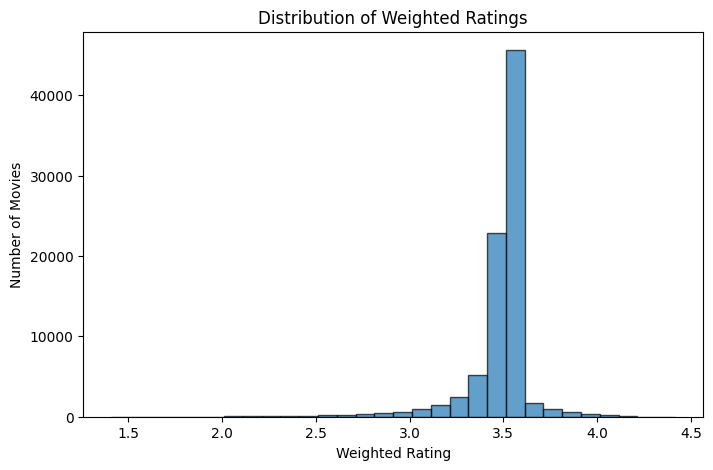

In [29]:
plt.figure(figsize=(8, 5))
plt.hist(popularity_df["weighted_rating"], bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Weighted Rating")
plt.ylabel("Number of Movies")
plt.title("Distribution of Weighted Ratings")
plt.show()


# **ANALYSIS ON USER RATINGS**

In [30]:
movies_ratings= raw_ratings.merge(raw_movies,on="movieId",how="inner").compute()
movies_ratings.head()

,userId,movieId,rating,title,genres,year
0,1,17,4.0,Sense and Sensibility,Drama|Romance,1995
1,1,25,1.0,Leaving Las Vegas,Drama|Romance,1995
2,1,29,2.0,The City of Lost Children,Adventure|Drama|Fantasy|Mystery|Sci-Fi,1995
3,1,30,5.0,Shanghai Triad,Crime|Drama,1995
4,1,32,5.0,Twelve Monkeys,Mystery|Sci-Fi|Thriller,1995


In [31]:
# Convert titles to lowercase
movies_ratings['title'] = movies_ratings['title'].str.lower()

movies_ratings.head()

,userId,movieId,rating,title,genres,year
0,1,17,4.0,sense and sensibility,Drama|Romance,1995
1,1,25,1.0,leaving las vegas,Drama|Romance,1995
2,1,29,2.0,the city of lost children,Adventure|Drama|Fantasy|Mystery|Sci-Fi,1995
3,1,30,5.0,shanghai triad,Crime|Drama,1995
4,1,32,5.0,twelve monkeys,Mystery|Sci-Fi|Thriller,1995


In [32]:
movies_ratings.shape[0]

24492584

In [33]:
ratings_count = movies_ratings.groupby("title")["rating"].count().reset_index()
ratings_count = ratings_count.rename(columns={"rating": "rating_count"})
ratings_count.head()

,title,rating_count
0,,69
1,bunny!,4
2,days of summer,15977
3,truth: the rape of 2 coreys,1
4,war of the buttons,15


In [34]:
users_count = movies_ratings.groupby("userId")["rating"].count().reset_index()
users_count = users_count.rename(columns={"rating": "rating_count"})
users_count.head()

,userId,rating_count
0,1,68
1,2,49
2,3,109
3,4,21
4,5,32


In [35]:
print(users_count.shape[0])
print(users_count["rating_count"].min())
print(users_count["rating_count"].max())
print(users_count["rating_count"].mean())

200874
1
20344
121.93008552625028


In [36]:
print(ratings_count.shape[0])
print(ratings_count["rating_count"].min())
print(ratings_count["rating_count"].max())
print(ratings_count["rating_count"].mean())

54521
1
102929
449.232112397058


# **COMPARING METRICS**

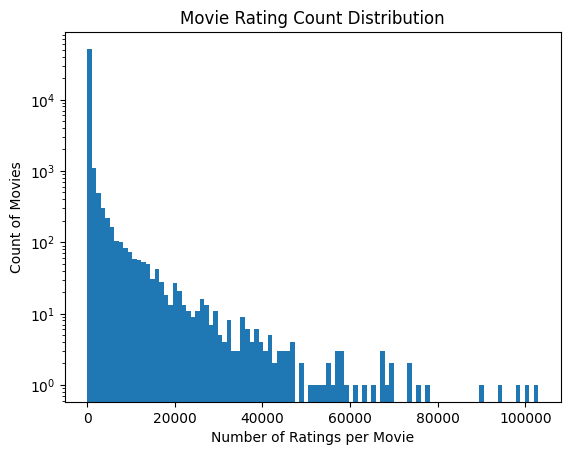

In [37]:
#graph for number of ratings against no. of movies
rating_counts = ratings_count["rating_count"]

plt.hist(rating_counts, bins=100, log=True)  # Log scale for better visualization
plt.xlabel("Number of Ratings per Movie")
plt.ylabel("Count of Movies")
plt.title("Movie Rating Count Distribution")
plt.show()

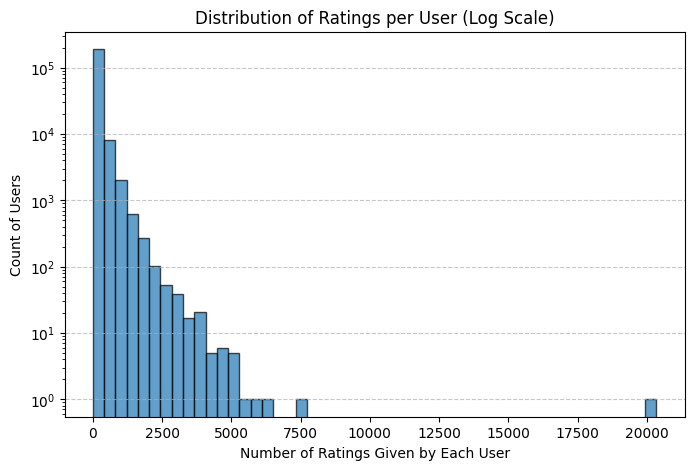

In [38]:
#graph for how many ratings a user has given
user_rating_counts = users_count["rating_count"]
plt.figure(figsize=(8, 5))
plt.hist(user_rating_counts, bins=50, log=True, edgecolor="black", alpha=0.7)
plt.xlabel("Number of Ratings Given by Each User")
plt.ylabel("Count of Users")
plt.title("Distribution of Ratings per User (Log Scale)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [39]:
#NO OF RATINGS FILTER
x = 50
# x = int(input("Enter Threshold"))
popular_movies = (ratings_count["rating_count"]>=x).sum()
total_movies = ratings_count.shape[0]
# Percentage of movies that meet the threshold
percentage = (popular_movies / total_movies) * 100
print(f"Number of Movies with number of ratings Greater than {x}: {popular_movies}/{total_movies} ({percentage:.2f}%)")

Number of Movies with number of ratings Greater than 50: 11347/54521 (20.81%)


In [40]:
ratings_count=ratings_count[(ratings_count['rating_count']>=x)]
ratings_count.shape[0]

11347

In [41]:
#NO. OF USERS FILTER
y = 10
# y = int(input("Enter Threshold"))
user_rating_count = users_count["rating_count"]
num_users = (users_count["rating_count"]>=y).sum()
total_movies = user_rating_count.shape[0]
# Percentage of users that meet the threshold
percentage = (num_users / total_movies) * 100
print(f"Number of Users with number of ratings Greater than {y} : {num_users}/{total_movies} ({percentage:.2f}%)")

Number of Users with number of ratings Greater than 10 : 198559/200874 (98.85%)


In [42]:
users_count=users_count[(users_count['rating_count']>=y)]
users_count.shape[0]

198559

In [43]:
users_count = users_count.rename(columns={"rating_count": "user_rating_count"})

In [44]:
 df = movies_ratings.merge(ratings_count,on="title",how="inner")
 df.head()

,userId,movieId,rating,title,genres,year,rating_count
0,1,17,4.0,sense and sensibility,Drama|Romance,1995,22251
1,1,25,1.0,leaving las vegas,Drama|Romance,1995,22525
2,1,29,2.0,the city of lost children,Adventure|Drama|Fantasy|Mystery|Sci-Fi,1995,9413
3,1,30,5.0,shanghai triad,Crime|Drama,1995,1300
4,1,32,5.0,twelve monkeys,Mystery|Sci-Fi|Thriller,1995,55275


In [45]:
 df = df.merge(users_count,on="userId",how="inner")
 df.head()

,userId,movieId,rating,title,genres,year,rating_count,user_rating_count
0,1,17,4.0,sense and sensibility,Drama|Romance,1995,22251,68
1,1,25,1.0,leaving las vegas,Drama|Romance,1995,22525,68
2,1,29,2.0,the city of lost children,Adventure|Drama|Fantasy|Mystery|Sci-Fi,1995,9413,68
3,1,30,5.0,shanghai triad,Crime|Drama,1995,1300,68
4,1,32,5.0,twelve monkeys,Mystery|Sci-Fi|Thriller,1995,55275,68


In [46]:
df.shape[0]

24142594

In [47]:
df.columns

Index(['userId', 'movieId', 'rating', 'title', 'genres', 'year',
       'rating_count', 'user_rating_count'],
      dtype='object')

# **CREATING MATRICES**

In [48]:
#creating sparse matrix
# df = df.compute()  # Convert to Pandas first (if it fits in memory)
df = df.astype({"userId": "category", "title": "category"})  # Convert manually
user_ids = df["userId"].cat.codes
movie_ids = df["title"].cat.codes
ratings = df["rating"]



In [49]:
sparse_matrix = csr_matrix((ratings, (user_ids, movie_ids)))

In [50]:
sparse_matrix.toarray()


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [51]:
sparse_matrix.shape

(198559, 11347)

In [52]:
print(sparse_matrix[:5, :5].toarray())


[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [53]:
print(f"Shape: {sparse_matrix.shape}")
print(f"Non-zero entries: {sparse_matrix.nnz}")
print(f"Density: {sparse_matrix.nnz / (sparse_matrix.shape[0] * sparse_matrix.shape[1]):.6f}")



Shape: (198559, 11347)
Non-zero entries: 24093874
Density: 0.010694


In [54]:
#creating cosine matrix
from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity between movies
movie_sim = cosine_similarity(sparse_matrix.T)

In [55]:
movie_sim

array([[1.        , 0.03854653, 0.03303919, ..., 0.00629237, 0.01544001,
        0.01504693],
       [0.03854653, 1.        , 0.03614511, ..., 0.0236634 , 0.02358204,
        0.03729956],
       [0.03303919, 0.03614511, 1.        , ..., 0.00971669, 0.00319582,
        0.00737634],
       ...,
       [0.00629237, 0.0236634 , 0.00971669, ..., 1.        , 0.01613721,
        0.01565391],
       [0.01544001, 0.02358204, 0.00319582, ..., 0.01613721, 1.        ,
        0.26354238],
       [0.01504693, 0.03729956, 0.00737634, ..., 0.01565391, 0.26354238,
        1.        ]])

In [56]:
movie_sim.shape

(11347, 11347)

In [57]:
# Check for NaN values
print(df[["title", "movieId"]].isnull().sum())

# Check for duplicates
print(df[["title", "movieId"]].duplicated().sum())


title      0
movieId    0
dtype: int64
24128903


# **RECOMMENDATION**

In [58]:
# Get mapping from title to category code (index in similarity matrix)
title_to_index = dict(zip(df["title"], df["title"].cat.codes))
index_to_title = dict(zip(df["title"].cat.codes, df["title"]))


In [59]:
def get_movie_recommendations(movie_titles, similarity_matrix, num_recommendations=5):
    all_recommendations = {}

    for movie_title in movie_titles:
        movie_title = movie_title.lower().strip()

        if movie_title not in title_to_index:
            all_recommendations[movie_title] = [f"Movie '{movie_title}' not found in dataset."]
            continue

        # movie_id = title_to_id[movie_title]
        # movie_index = df[df["movieId"] == movie_id].index[0]
        if movie_title not in title_to_index:
            return f"Movie '{movie_title}' not found in dataset."
        movie_index = title_to_index[movie_title]


        if movie_index >= similarity_matrix.shape[0]:
            all_recommendations[movie_title] = [f"Movie index {movie_index} out of bounds for similarity matrix."]
            continue

        similarity_scores = list(enumerate(similarity_matrix[movie_index]))
        sorted_movies = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations+1]

        recommendations = []

        for i in sorted_movies:
            recommended_index = i[0]
        
            if recommended_index not in index_to_title:
                continue
        
            recommended_movie_title = index_to_title[recommended_index]
            recommendations.append(recommended_movie_title)

        all_recommendations[movie_title] = recommendations

    return all_recommendations


In [60]:
movie_list = ["inception", "toy story", "the conjuring"]

recommendations = get_movie_recommendations(movie_list, movie_sim)

for movie, recs in recommendations.items():
    print(f"\nTop recommendations for '{movie}':")
    for rec in recs:
        print(f"- {rec}")


Top recommendations for 'inception':
- the dark knight
- interstellar
- the dark knight rises
- shutter island
- inglourious basterds

Top recommendations for 'toy story':
- toy story 2
- forrest gump
- jurassic park
- the lion king
- independence day

Top recommendations for 'the conjuring':
- the conjuring 2
- insidious
- sinister
- it follows
- insidious: chapter 2
